In [39]:
import os
import requests
import pandas as pd
from pyspark.sql import SparkSession
from tmlt.analytics.privacy_budget import PureDPBudget, RhoZCDPBudget
from tmlt.analytics.query_builder import QueryBuilder
from tmlt.analytics.session import Session
from pyspark.sql.functions import desc, asc

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Setup

In [3]:
spark = SparkSession.builder.getOrCreate()

22/07/07 11:26:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark = (
    SparkSession.builder
    .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")
    .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")
    .getOrCreate()
)

In [112]:
# r = requests.get(
#     'https://tumult-public.s3.amazonaws.com/library-members.csv',
# )

# with open("members.csv", "w") as f:
#     f.write(r.text)

members_df = spark.read.csv("members2.csv", header=True, inferSchema=True)

members_df.count()

54217

### Creating a Session with:
    
1. **Privacy Budget**: Specifies what privacy guarantee 
2. **Source_id**: Identifier for the DataFrame

In [107]:
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(3),
    source_id="members",
    dataframe=members_df
)

### Evaluating queries in a Session

### Counting

In [108]:
total_count = members_df.count()
print(total_count)

54217


In [16]:
import seaborn as sns 
import matplotlib.pyplot as plt

### Group-by queries

In [8]:
from tmlt.analytics.keyset import KeySet

In [9]:
edu_levels = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ]
})

In [10]:
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(epsilon=float('inf')),
    source_id="members",
    dataframe=members_df,
)

###  Impact of clamping 

- As suggested by their name, the input data will be clamped within these bounds.
- The amount of perturbation in the data will (typically) increase with the size of the clamping bounds.

**Choice of clamping bounds**:  In those cases, it is often a good idea to choose clamping bounds that aren’t absolute limits over the data range, but are such that most values would fall within these bounds

**Note**: Clamping it can often make your data analysis more robust: it reduces the contribution of outlier data points, which could otherwise have an outsized influence on the results.

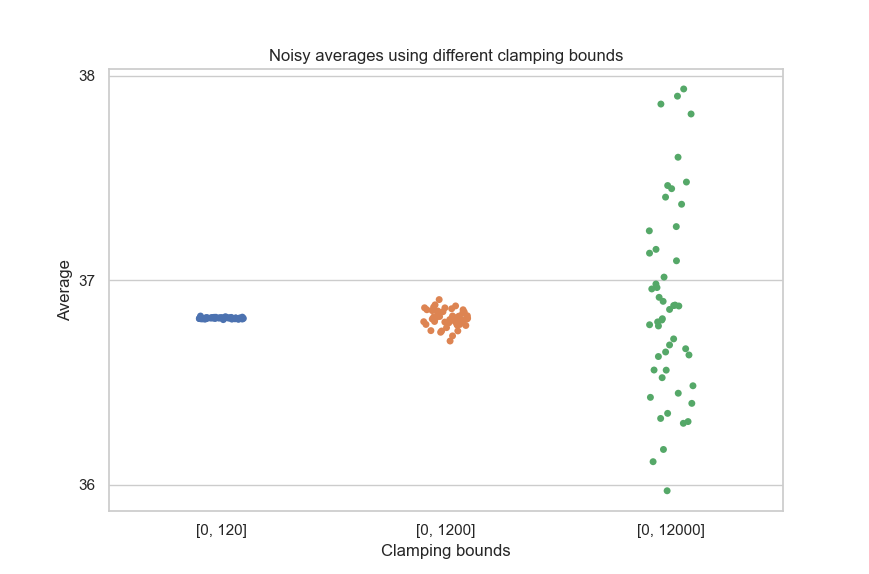

###  Impact of privacy budget 

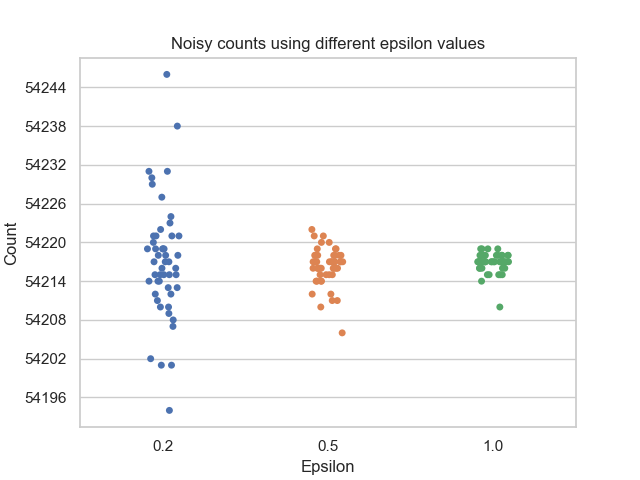

In [11]:
# configuring a session
session = Session.from_dataframe(
    privacy_budget=PureDPBudget(epsilon=float('inf')),
    source_id="members",
    dataframe=members_df,
)

# group by query 
edu_sum_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .sum("age", low=0, high=120) # clamping
)

# setting the privacy budget
edu_sum_ages = session.evaluate(
    edu_sum_age_query,
    privacy_budget=PureDPBudget(1),
)

# edu_sum_ages.sort("age_sum").show(truncate=False)

In [17]:
def visualise(perturbed_df, true_df): 
    pd_perturbed_age_sum = edu_sum_ages.toPandas() #.rename(columns={'sum(age)': 'age_sum'})
    pd_perturbed_age_sum['state'] = ['noisy']*pd_perturbed_age_sum.shape[0]

    pd_true_age_sum = true_df.groupBy('education_level').sum('age').sort(asc("sum(age)"))
    pd_true_age_sum = pd_true_age_sum.toPandas().rename(columns={'sum(age)': 'age_sum'})
    pd_true_age_sum['state'] = ['original']*pd_true_age_sum.shape[0]
    pd_true_age_sum

    true_perturbed_age_sum = pd_perturbed_age_sum.append(pd_true_age_sum, ignore_index=True)
    true_perturbed_age_sum
    
    sns.catplot(x="education_level", y="age_sum", hue="state", kind="bar", data=true_perturbed_age_sum)
    plt.xticks(rotation=45)
    return plt 


In [13]:
visualise(edu_sum_ages, members_df).show()

NameError: name 'sns' is not defined

 ##  Impact of the privacy budget, clamping bound and dataset size

Members --> Firms 

Education Level --> Sectors 

Age --> Number of researchers, amount

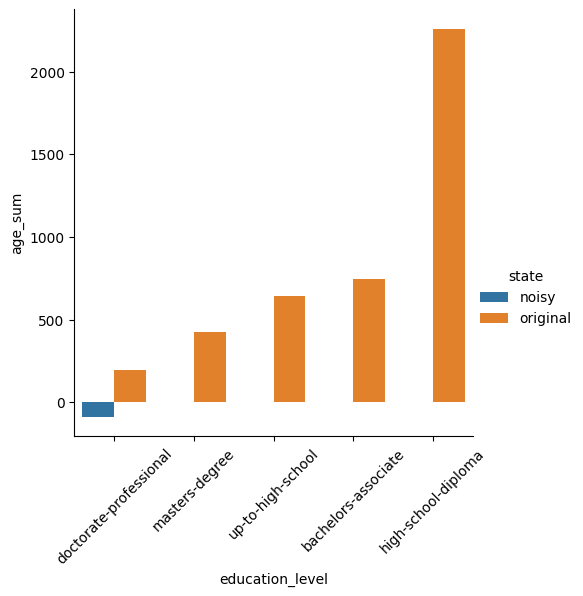

+--------------------+-----+
|     education_level|count|
+--------------------+-----+
| high-school-diploma|   47|
| bachelors-associate|   15|
|   up-to-high-school|   27|
|      masters-degree|    8|
|doctorate-profess...|    3|
+--------------------+-----+



In [72]:
# knobs to handle privacy and utility trade-off for sum query

# 1. sampling data from 54217 records 
SAMPLE_SIZE = 100 # (FIRMS)

# 2. privacy budget for the query -- epsilon
PRIVACY_BUDGET = 5

# 3. low and high clamping bounds
CLAMPING_BOUNDS = [0, 1000] # (#REARCHERS, AMOUNT)

sampled_data = members_df.limit(SAMPLE_SIZE) 

# each individual has an influence on at most one bucket (SECTORS)
edu_levels = KeySet.from_dict({
    "education_level": [
        # "up-to-high-school",
        # "high-school-diploma",
        # "bachelors-associate",
        # "masters-degree",
        "doctorate-professional",
    ]
})

session = Session.from_dataframe(
    # adding laplacian noise 
    privacy_budget=RhoZCDPBudget(PRIVACY_BUDGET), # privacy budget for the session
    source_id="members",
    dataframe=sampled_data
)

# group by query 
edu_sum_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .sum("age", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
edu_sum_ages = session.evaluate(
    edu_sum_age_query,
    privacy_budget=RhoZCDPBudget(PRIVACY_BUDGET), #RhoZCDPBudget
)

# show visualisations
visualise(edu_sum_ages, sampled_data).show()
sampled_data.groupby(sampled_data.education_level).count().show()

# Coming here

+-----+
|count|
+-----+
|  200|
+-----+



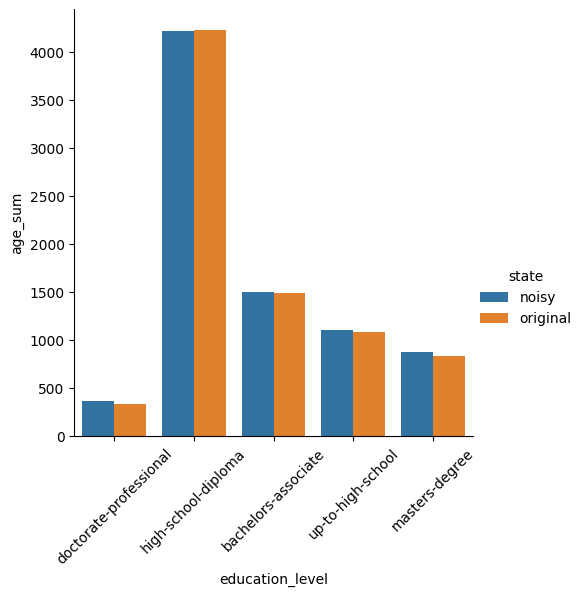

+--------------------+-----+
|     education_level|count|
+--------------------+-----+
| high-school-diploma|   92|
| bachelors-associate|   33|
|   up-to-high-school|   53|
|      masters-degree|   16|
|doctorate-profess...|    6|
+--------------------+-----+

sensitivity: 1
noise scale: 0.05
variance: 0.005000000000000001
confidence interval: (-0.1497866136776995, 0.1497866136776995)


In [91]:
# knobs to handle privacy and utility trade-off for sum query

# 1. sampling data from 54217 records 
SAMPLE_SIZE = 200 # (FIRMS)

# 2. privacy budget for the query -- epsilon
PRIVACY_BUDGET = 20

# 3. low and high clamping bounds
CLAMPING_BOUNDS = [0, 120] # (#REARCHERS, AMOUNT)

sampled_data = members_df.limit(SAMPLE_SIZE) 

# each individual has an influence on at most one bucket (SECTORS)
edu_levels = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ]
})

session = Session.from_dataframe(
    # adding laplacian noise 
    privacy_budget=PureDPBudget(epsilon=float(30)), # privacy budget for the session
    source_id="members",
    dataframe=sampled_data
)

# group by query 
edu_sum_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .sum("age", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
edu_sum_ages = session.evaluate(
    edu_sum_age_query,
    privacy_budget=PureDPBudget(10), #RhoZCDPBudget
)



count_query = QueryBuilder("members").count(mechanism=CountMechanism.LAPLACE)
result = session.evaluate(count_query, PureDPBudget(1))
result.show()


# show visualisations
visualise(edu_sum_ages, sampled_data).show()
sampled_data.groupby(sampled_data.education_level).count().show()


# print(session._stability["members"])
from scipy.stats import laplace

# formula is noise_scale = stability/epsilon
noise_scale_exact = session._stability["members"]/PRIVACY_BUDGET
noise_scale_float = float(noise_scale_exact)

# https://en.wikipedia.org/wiki/Laplace_distribution
noise_rvs = laplace(loc=0, scale=noise_scale_float) # b value for Laplace distribution

print(f"sensitivity: {session._stability['members']}")
print(f"noise scale: {noise_scale_float}")
print(f"variance: {noise_rvs.var()}")
print(f"confidence interval: {noise_rvs.interval(0.95)}")

In [86]:
import pandas as pd
from pyspark.sql import SparkSession

from tmlt.analytics.privacy_budget import PureDPBudget
from tmlt.analytics.query_builder import QueryBuilder
from tmlt.analytics.query_expr import CountMechanism
from tmlt.analytics.session import Session

spark = SparkSession.builder.getOrCreate()
data = spark.createDataFrame(pd.DataFrame({"column": list(range(10))}))

budget = PureDPBudget(1)
session = Session.from_dataframe(
    privacy_budget=budget,
    source_id="my_data",
    dataframe=data,
)

# More complicated transformations may result in higher stability
filter_query = QueryBuilder("my_data").filter("column < 50")
session.create_view(filter_query, "filtered_data", cache=False)

count_query = QueryBuilder("filtered_data").count(mechanism=CountMechanism.LAPLACE)
result = session.evaluate(count_query, budget)
result.show()

# Determining the variance of distribution
from scipy.stats import laplace

# formula is noise_scale = stability/epsilon
noise_scale_exact = session._stability["filtered_data"]/budget.epsilon
noise_scale_float = float(noise_scale_exact)

# https://en.wikipedia.org/wiki/Laplace_distribution
noise_rvs = laplace(loc=0, scale=noise_scale_float) # b value for Laplace distribution
print(f"sensitivity: {session._stability['filtered_data']}")
print(f"noise scale: {noise_scale_float}")
print(f"variance: {noise_rvs.var()}")
print(f"confidence interval: {noise_rvs.interval(0.95)}")

+-----+
|count|
+-----+
|   14|
+-----+

sensitivity: 1
noise scale: 1.0
variance: 2.0
confidence interval: (-2.99573227355399, 2.99573227355399)


+-----+
|count|
+-----+
|  200|
+-----+



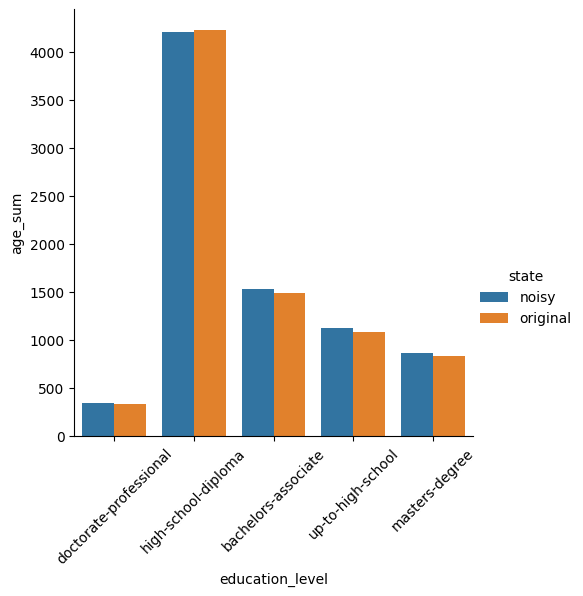

+--------------------+-----+
|     education_level|count|
+--------------------+-----+
| high-school-diploma|   92|
| bachelors-associate|   33|
|   up-to-high-school|   53|
|      masters-degree|   16|
|doctorate-profess...|    6|
+--------------------+-----+

1


In [95]:
# knobs to handle privacy and utility trade-off for sum query

# 1. sampling data from 54217 records 
SAMPLE_SIZE = 200 # (FIRMS)

# 2. privacy budget for the query -- epsilon
PRIVACY_BUDGET = 20

# 3. low and high clamping bounds
CLAMPING_BOUNDS = [0, 120] # (#REARCHERS, AMOUNT)

sampled_data = members_df.limit(SAMPLE_SIZE) 

# each individual has an influence on at most one bucket (SECTORS)
edu_levels = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ]
})

session = Session.from_dataframe(
    # adding laplacian noise 
    privacy_budget=RhoZCDPBudget(rho=float(30)), # privacy budget for the session
    source_id="members",
    dataframe=sampled_data
)

# group by query 
edu_sum_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .sum("age", low=CLAMPING_BOUNDS[0], high=CLAMPING_BOUNDS[1]) 
)

# privacy budget for the query
edu_sum_ages = session.evaluate(
    edu_sum_age_query,
    privacy_budget=RhoZCDPBudget(10), #RhoZCDPBudget
)



count_query = QueryBuilder("members").count(mechanism=CountMechanism.LAPLACE)
result = session.evaluate(count_query, RhoZCDPBudget(1))
result.show()


# show visualisations
visualise(edu_sum_ages, sampled_data).show()
sampled_data.groupby(sampled_data.education_level).count().show()

# print(session._stability["members"])

epsilon = 

noise_scale = float(session._stability["members"]/epsilon) 
upper = 0
p = 0.95
while discrete_gaussian_cmf(upper, noise_scale**2) <= 1 - ((1 - p)/2):
    upper += 1

interval = (-upper, upper)
print(interval)




# # print(session._stability["members"])
# from scipy.stats import laplace

# # formula is noise_scale = stability/epsilon
# noise_scale_exact = session._stability["members"]/PRIVACY_BUDGET
# noise_scale_float = float(noise_scale_exact)

# # https://en.wikipedia.org/wiki/Laplace_distribution
# noise_rvs = laplace(loc=0, scale=noise_scale_float) # b value for Laplace distribution

# print(f"sensitivity: {session._stability['members']}")
# print(f"noise scale: {noise_scale_float}")
# print(f"variance: {noise_rvs.var()}")
# print(f"confidence interval: {noise_rvs.interval(0.95)}")

In [94]:
from tmlt.core.utils.distributions import discrete_gaussian_cmf

noise_scale = 7
upper = 0
p = 0.95
while discrete_gaussian_cmf(upper, noise_scale**2) <= 1 - ((1 - p)/2):
    upper += 1

interval = (-upper, upper)
print(interval)

(-14, 14)
